![DeepNeuro](https://github.com/QTIM-Lab/DeepNeuro/raw/master/package_resources/logos/DeepNeuro_alt.PNG?raw=true)

# Loading, Preprocessing, and Augmenting Data Using DeepNeuro

In this notebook, you will learn how to load, preprocess, and augment data with DeepNeuro. DeepNeuro loads data from either structure folders, filepaths, or .csv files into DataCollection objects. DataCollection objects have pre-coded methods to perform data preprocessing, data augmentation, and patch extraction. They also can be automatically sampled for the purpose of training neural networks with DeepNeuro's DeepNeuroModel objects.

You are going to get started creating a DataCollection object and applying some preprocessing steps. First, however, you need to get DeepNeuro installed, and import the package.

In [1]:
# pip install deepneuro tensorflow-gpu keras

import deepneuro

You will work with two datasets from the TCGA-GBM dataset for this tutorial, available from The Cancer Imaging Archive (TCIA) and this link: [link](https://wiki.cancerimagingarchive.net/display/Public/TCGA-GBM).

We will load this dataset using DeepNeuro's load module into a local folder in your CoLab directory.

In [2]:
from deepneuro.load.load import load

load('sample_gbm_nifti', output_datapath='./TCIA_GBM.zip')

'./TCIA_GBM.zip'

You should see two folders labeled 'TRAINING' and 'TESTING' contained within a folder titled 'TCIA_GBM'. Both of these folders contain individual patient folders, and each of these contain five NiFTi files each. Four of these files should code for different MR sequences of a patient with glioblastoma. The other file should be a segmentation file, containing voxelwise annotations for enhancing tumor, necrotic tissue, and edematous tissue in the brain.

For most deep learning experiments, you should hopefully have more than three patients. For this tutorial, however, we will stick with three because it's faster to load data that way :). We will have two patients in the training set, and one patient in the test set.

Let's start with our training data. Our first step will be to associate this two-patient dataset with a DataCollection, DeepNeuro's one-size-fits-all data processing object for data conversion, preprocessing, and augmentation.

In [23]:
from deepneuro.data.data_collection import DataCollection

training_data_sources = {
    'directories': {
                'TCIA_GBM/TRAINING':
                {'input_data': ['*_flair.nii.gz*', '*_t2.nii.gz*', '*_t1.nii.gz', '*_t1Gd.nii.gz'], 
                 'ground_truth': ['*GlistrBoost_ManuallyCorrected.nii.gz']}},
}

training_data = DataCollection(data_sources=training_data_sources, verbose=True)

('Gathering image data from...', {'TCIA_GBM/TRAINING': {'ground_truth': ['*GlistrBoost_ManuallyCorrected.nii.gz'], 'input_data': ['*_flair.nii.gz*', '*_t2.nii.gz*', '*_t1.nii.gz', '*_t1Gd.nii.gz']}}, '\n')
('Found', 2, 'number of cases..')


Great, it worked! But what does it mean to have your data in a DataCollection? We can start to get a sense using DeepNeuro's check_data function.

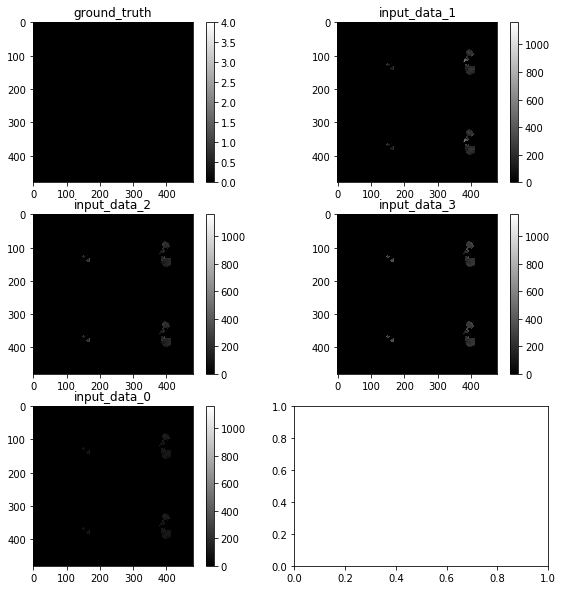

In [17]:
# We start off we some code to making plotting in Juypter/Colab Notebooks work correctly.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

from deepneuro.utilities.visualize import check_data

figure = check_data(data_collection=training_data)

We can see the four sequences of our datasets labeled 0, 1, 2, and 3. We can also see our "ground truth", the multi-tissue tumor segmentation.

So, we have our data available via a DataCollection. Can we start deep learning on it? No! Here are a few reasons:
- As we can see from the  MR sequences are scaled variably between 0 and 1000. Because we don't know if they came from the same scanner, we do not have assurances that these values will be on the same scale from patient to patient. Also, inputs to neural networks are conventional scaled to have a mean centered on zero and a standard deviation of 1, which our sequences certainly do not have.

- Our ground truth is scaled from 0 to 4. Most deep learning cost functions for classification expect one-hot encoding. This means that each relevant classification is either 0 or 1, and that each class if separated into a different channel of the image. We will likely have training problems down the way if we do not adjust our data.

- Can you train a machine learning algorithm on two pieces of data? Not likely! And even if you could, how are you going to fit a whole MRI scan into memory on anything but the most powerful GPUs? A common solution to both of these problems is to split your data into smaller patches, decreasing memory requirements and increasing effective dataset size. There are also other data augmentations that can be put into place to push the effective size of our data even higher.

Luckily, DeepNeuro has utilities for performing each of these preprocessing steps and augmentations. We cover them below.

## Normalization -- MR Sequence Data

In [24]:
from deepneuro.preprocessing.signal import ZeroMeanNormalization

normalization_preprocessor = ZeroMeanNormalization(data_groups=['input_data'], 
                                                   verbose=False, 
                                                   normalize_by_channel=True, 
                                                   mask_zeros=True)
training_data.append_preprocessor(normalization_preprocessor)

# figure = check_data(data_collection=training_data)

## Reformatting -- Voxelwise Segmentation Data

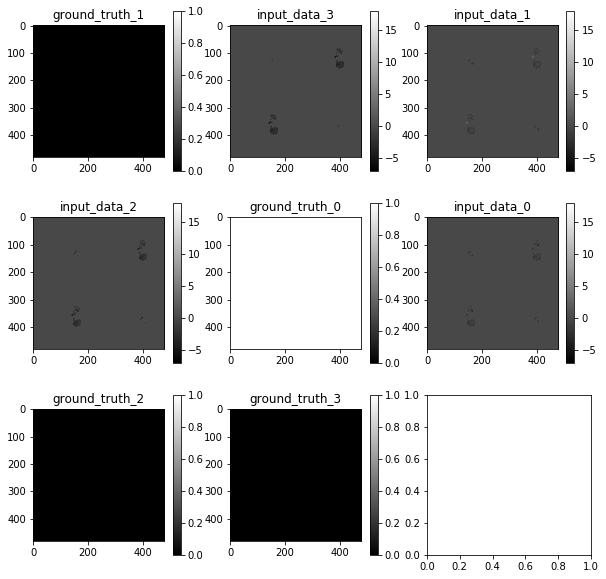

In [25]:
from deepneuro.preprocessing.transform import SplitData

one_hot_preprocessor = SplitData(data_groups=['ground_truth'], label_splits=[0, 1, 2, 4], verbose=False)
training_data.append_preprocessor([one_hot_preprocessor])

figure = check_data(data_collection=training_data)

## Augmentation -- Patch Extraction

In [ ]:
from deepneuro.augmentation.subsample import PatchExtraction



## Augmentation -- Rotations and Flips